In [1]:
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import tensorflow_privacy
from typing import Tuple

print("gpu available:", tf.test.is_gpu_available())
rng = np.random.RandomState(123)
tf.random.set_seed(42)
plt.rcParams['font.size'] = 18

dtype = np.float64
gpflow.config.set_default_float(dtype)

2022-07-19 19:36:27.070366: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-19 19:36:27.073469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 19:36:27.073480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
gpu available: False


2022-07-19 19:36:28.734139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-19 19:36:28.777765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 19:36:28.777821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-19 19:36:28.777856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot ope

In [2]:
N = 10_000  # Number of training observations
def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 3) + 0.5 * np.sin(x * 15)

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)
data = (X, Y)
X.dtype, Y.dtype

(dtype('float64'), dtype('float64'))

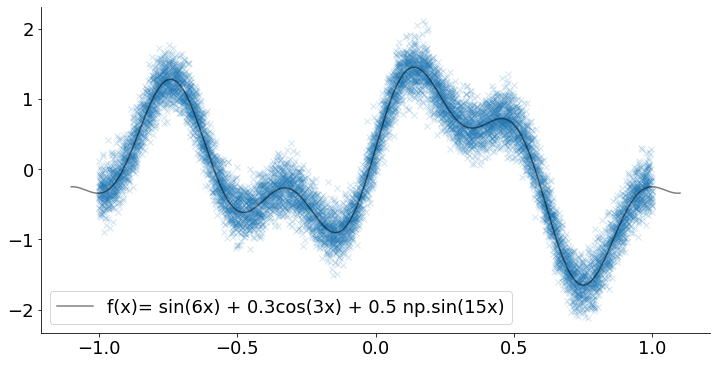

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "x", alpha=0.2)
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, c="k", alpha=0.5, label='f(x)= sin(6x) + 0.3cos(3x) + 0.5 np.sin(15x)')
sns.despine()
plt.legend()

In [4]:
from gpflow.base import RegressionData
class SVGP_psg(gpflow.models.svgp.SVGP):
    def elbo(self, data: RegressionData, reduce:bool=False) -> tf.Tensor:
        """
        This gives a variational bound (the evidence lower bound or ELBO) on
        the log marginal likelihood of the model.
        """
        X, Y = data
        kl = self.prior_kl()
        f_mean, f_var = self.predict_f(X, full_cov=False, full_output_cov=False)
        var_exp = self.likelihood.variational_expectations(f_mean, f_var, Y)
        if self.num_data is not None:
            num_data = tf.cast(self.num_data, kl.dtype)
            minibatch_size = tf.cast(tf.shape(X)[0], kl.dtype)
            scale = num_data / minibatch_size
        else:
            scale = tf.cast(1.0, kl.dtype)
        if reduce:
            out = tf.reduce_sum(var_exp) * scale - kl
        else:
            out = var_exp * scale - kl
        return out

In [5]:
def make_SVGP_model(num_inducing:int, num_data:int, kernel=gpflow.kernels.SquaredExponential(), likelihood=gpflow.likelihoods.Gaussian()):
    # TODO change this to be randomly selected points
    Z = X[:num_inducing, :].copy()  # Initialize inducing locations to the first M inputs in the dataset
    model = SVGP_psg(kernel, likelihood, Z, num_data=num_data)
    return model

2022-07-19 19:36:29.774313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
m = make_SVGP_model(num_inducing=50, num_data=len(X))
m

name,class,transform,prior,trainable,shape,dtype,value
SVGP_psg.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP_psg.inducing_variable.Z,Parameter,Identity,,True,"(50, 1)",float64,[[0.39293837...
SVGP_psg.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[0....
SVGP_psg.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[1., 0., 0...."


In [7]:
elbo = tf.function(m.elbo)

In [8]:
# check elbo returns a vector not a scalar
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(100))
elbo(next(train_iter)).shape

TensorShape([100])

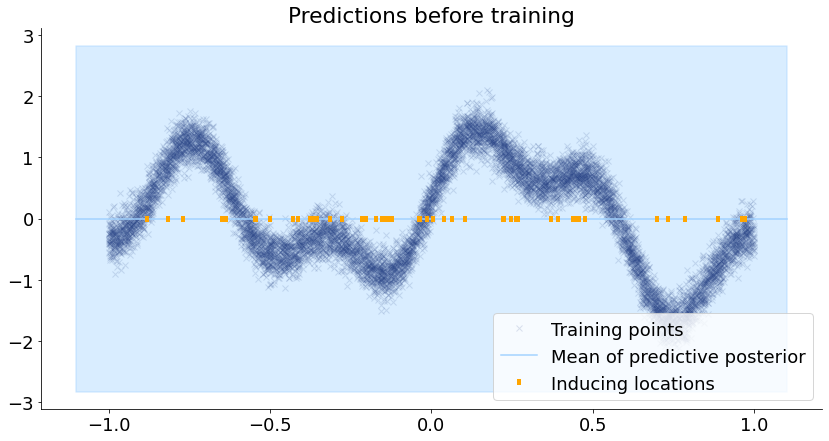

In [9]:
def plot(title=""):
    plt.figure(figsize=(14, 7))
    plt.title(title)
    pX = np.linspace(-1.1, 1.1, 100, dtype=dtype)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, "x", label="Training points", alpha=0.15, color='#264185')
    (line,) = plt.plot(pX, pY, lw=1.5, label="posterior mean", color='#A2D2FF', alpha=1.0)
    plt.fill_between(
        pX[:, 0],
        (pY - 2 * pYv ** 0.5)[:, 0],
        (pY + 2 * pYv ** 0.5)[:, 0],
        color='#A2D2FF',
        alpha=0.4,
        lw=1.5,
    )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=4, label="Inducing locations", color='orange')
    plt.legend(loc="lower right")
    sns.despine()

plot(title="Predictions before training")

In [10]:
from dp_gp.dp_tools.dp_gd_optimizer import VectorizedDPKerasAdamOptimizer

BATCH_SIZE = 128
L2_CLIP = 10.0
NOISE_MULT = 10.0
LR = 1e-2
DP=True

if DP:
        print("using private optimizer")
        opt = VectorizedDPKerasAdamOptimizer(
                l2_norm_clip=L2_CLIP,
                noise_multiplier=NOISE_MULT,
                num_microbatches=BATCH_SIZE,
                learning_rate=LR,
        )
else:
        print("using non private optimizer")
        opt = tf.keras.optimizers.Adam(learning_rate=LR)

using private optimizer


In [11]:
# We turn off training for inducing point locations | TODO: WHY?
gpflow.set_trainable(m.inducing_variable, False)

def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor], dp:bool=True):
    loss_fn = lambda: model.training_loss(batch)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss = model.training_loss(batch)
        batch_loss = tf.math.reduce_mean(loss) 
        if dp:
            dp_grads = opt.get_gradients(
                loss, model.trainable_variables)
            opt.apply_gradients(zip(dp_grads, model.trainable_variables))
        else:
            grads = tape.gradient(batch_loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
    return batch_loss

In [12]:
def simple_training_loop(
            model: gpflow.models.SVGP,
            train_dataset:tf.data.Dataset,
            batch_size:256,
            optim_steps: int = 5_000,
            logging_batch_freq: int = 10):
            
    losses, elbos = [], []
    tf_optimization_step = tf.function(optimization_step)
    train_iter = iter(train_dataset.batch(batch_size)) # check how to do this in kosher way for DP
    with tqdm(total=optim_steps) as pbar:
        for i, (x_batch, y_batch) in enumerate(train_iter):
            loss = tf_optimization_step(model, (x_batch, y_batch), dp=DP)
            losses.append(loss)
            pbar.update()
            if i % logging_batch_freq == 0:
                elbo = tf.math.reduce_mean(model.elbo(data))
                elbos.append(elbo.numpy())
                pbar.set_description(f"loss: {loss:.3f} ELBO: {elbo.numpy():.3f}")
            if i > optim_steps:
                return losses, elbos

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)
train_losses, train_elbos = simple_training_loop(
            model=m,
            train_dataset=train_dataset,
            batch_size=BATCH_SIZE,
            optim_steps=15_000,
            logging_batch_freq=25)

loss: 118.505 ELBO: -102.066: : 15002it [06:41, 37.38it/s]                         


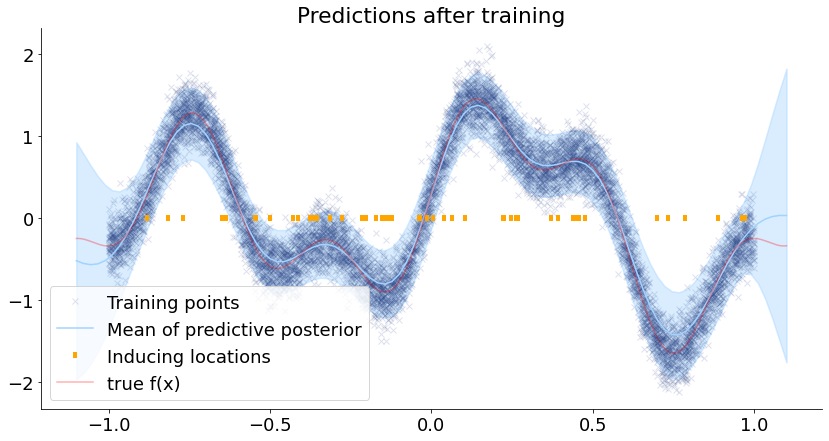

In [14]:
plot("Predictions after training")
plt.plot(Xt, Yt, c="red", alpha=0.3, label='true f(x)')
plt.legend(loc="lower left")
plt.show()

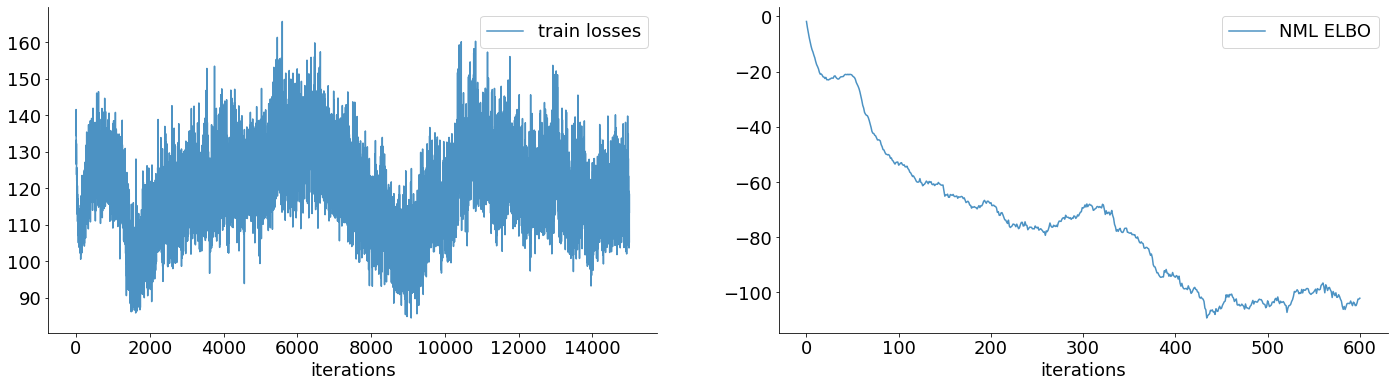

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
ax[0].plot(train_losses, label="train losses", alpha=0.8)
ax[0].set_xlabel("iterations")
ax[0].legend()
sns.despine()
ax[1].plot(train_elbos, label="NML ELBO", alpha=0.8)
ax[1].set_xlabel("iterations")
ax[1].legend()
sns.despine()